In [1]:
import sys
import platform
from os.path import join, exists, abspath, dirname
from os import getcwd, makedirs
from glob import glob

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps, cm
from matplotlib import colors as mcolors
import scipy
from scipy.stats import ttest_1samp, ttest_rel
from sklearn.metrics import r2_score
import seaborn as sns

from tqdm import tqdm

In [2]:
import nibabel as nb
from nilearn import plotting, image
from nipype.interfaces import fsl

In [3]:
dir_current = getcwd().replace('\\','/')

tmp = dir_current.split('/')
idx = [ii for ii, s in enumerate(tmp) if s=='github'][0]

dir_git = '/'.join(tmp[:idx+1])
dir_git

'/home/sungbeenpark/github'

In [4]:
dname = join(dir_git,'nitools')
sys.path.append(dname)
import nitools as nt

In [5]:
dname = join(dir_git,'SUITPy')
sys.path.append(dname)
import SUITPy as suit

In [6]:
dname = join(dir_git)
sys.path.append(dname)
import surfAnalysisPy as surf

In [7]:
dname = join(dir_git,'SeqSpatialSupp_fMRI')
sys.path.append(dname)
from SSS import deal_spm
from SSS import util as su
from SSS import stat as sstat
from SSS import plot as splt
from SSS import image as simage
from SSS import glmsingle as ssingle

---

In [8]:
mpl.rcParams['font.family'] = 'Helvetica'

### Font를 못 읽어 온다면, matplotlib 캐시 초기화
`rm -rf ~/.cache/matplotlib`

---

In [9]:
list_sn = su.get_list_sn()
# list_roi = simage.get_list_roi()
list_run = su.get_list_run()

---

In [10]:
dir_roi = su.get_dir_roi()

In [11]:
hem = 'L'

---

In [12]:
glm = 2
dir_glm = join(ssingle.get_dir_glmsingle(glm))

In [13]:
dir_surf = join(ssingle.get_dir_glmsingle(),'surfaceWB')
dir_surf

'/mnt/f/SeqSpatialSupp_fMRI/GLMsingle/surfaceWB'

In [14]:
dir_group = join(dir_surf,'group')

---
---

In [15]:
def get_df_idx(subj, glm):
    reginfo = deal_spm.load_reginfo(subj,dir_glm)
    df_idx = pd.DataFrame()
    df_idx['letter'] = np.array([True if '_L' in name else False for name in reginfo.name])
    df_idx['spatial'] = np.array([True if '_S' in name else False for name in reginfo.name])
    df_idx['B'] = np.array([True if 'B_' in name else False for name in reginfo.name])
    df_idx['S'] = np.array([True if 'S_' in name else False for name in reginfo.name])
    df_idx['C'] = np.array([True if 'C_' in name else False for name in reginfo.name])
    df_idx['N'] = np.array([True if 'N_' in name else False for name in reginfo.name])
    return df_idx

In [16]:
df_idx = get_df_idx(subj='S01', glm=glm)
df_idx

,letter,spatial,B,S,C,N
0,False,False,False,False,False,False
1,False,True,False,False,True,False
2,True,False,False,True,False,False
3,True,False,False,False,True,False
4,False,True,False,False,False,True
...,...,...,...,...,...,...
539,False,True,False,False,True,False
540,True,False,False,True,False,False
541,False,True,False,False,False,True
542,True,False,False,True,False,False


## i) Calculate Contrasts

In [19]:
dataset = {}
for ii, nn in enumerate(tqdm(list_sn)):
    subj = 'S'+nn

    ## ============ beta =========== ##
    ## index
    df_idx = get_df_idx(subj=subj, glm=glm)

    ## load beta
    fname = join(dir_surf,'glm_%1d'%glm,subj,'%s.%s.glm_%d.beta.func.gii'%(subj,hem,glm))
    darrays = nb.load(fname).darrays
    data = np.ones((len(df_idx),32492)) * np.nan
    for jj, darray in enumerate(darrays):
        data[jj] = darray.data
    ## ============================= ##
    ## contrast
    ## beta difference
    sss='beta_mean'
    for cue in ['letter', 'spatial']:
        if ii==0:
            dataset['B_'+cue] = np.ones((len(list_sn),32492)) * np.nan
            dataset['S_'+cue] = np.ones((len(list_sn),32492)) * np.nan
            dataset['C_'+cue] = np.ones((len(list_sn),32492)) * np.nan
            dataset['N_'+cue] = np.ones((len(list_sn),32492)) * np.nan
            dataset['within_'+cue] = np.ones((len(list_sn),32492)) * np.nan
            dataset['between_'+cue] = np.ones((len(list_sn),32492)) * np.nan
        idx_B = ((df_idx[cue])&(df_idx.B)).values.astype(int)
        idx_S = ((df_idx[cue])&(df_idx.S)).values.astype(int)
        idx_C = ((df_idx[cue])&(df_idx.C)).values.astype(int)
        idx_N = ((df_idx[cue])&(df_idx.N)).values.astype(int)
        ## condition B
        contrast = np.copy(idx_B/idx_B.sum()).astype(float)
        assert contrast[contrast>0].sum()==1
        dataset['B_'+cue][ii,:] = contrast@data
        ## condition S
        contrast = np.copy(idx_S/idx_S.sum()).astype(float)
        assert contrast[contrast>0].sum()==1
        dataset['S_'+cue][ii,:] = contrast@data
        ## condition B
        contrast = np.copy(idx_C/idx_C.sum()).astype(float)
        assert contrast[contrast>0].sum()==1
        dataset['C_'+cue][ii,:] = contrast@data
        ## condition N
        contrast = np.copy(idx_N/idx_N.sum()).astype(float)
        assert contrast[contrast>0].sum()==1
        dataset['N_'+cue][ii,:] = contrast@data
        ## within Rep - within No-Rep
        contrast = np.copy(idx_B/idx_B.sum() - idx_C/idx_C.sum()).astype(float)
        assert contrast[contrast>0].sum()==1
        dataset['within_'+cue][ii,:] = contrast@data
        ## between Rep - between No-Rep
        contrast = np.copy(idx_S/idx_S.sum() - idx_N/idx_N.sum()).astype(float)
        assert contrast[contrast>0].sum()==1
        dataset['between_'+cue][ii,:] = contrast@data
    ## ============================= ##

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:11<00:00,  1.01it/s]


### Save the dataset as cifti

In [20]:
dir_output = join(dir_surf,'glm_%1d'%glm)
for key, value in dataset.items():
    simage.save_surf2cifti(
        data=value,
        dir_output=dir_output,
        label_axis=['S'+sn for sn in list_sn],
        prefix='cifti.%s.glm_%1d.%s.%s'%(hem,glm,sss,key)
    )

Should run `run.smooth_cii.zsh -i <input cii>` to smooth the result.

---

## ii) Load the dataset from cifti

In [21]:
dir_work = join(dir_surf,'glm_%1d'%glm)

In [22]:
dataset = {}
for c1 in ['B', 'S', 'C', 'N', 'within', 'between']:
    for c2 in ['letter','spatial']:
        cond = '%s_%s'%(c1,c2)
        fname = join(dir_work, 'smooth.cifti.%s.glm_%1d.beta_mean.%s.dscalar.nii'%(hem,glm,cond))
        dataset[cond] = nb.load(fname).get_fdata()

### t-test

In [23]:
for key, value in dataset.items():
    data = np.ones((2,32492)) * np.nan
    ## coeffcient
    data[0] = np.mean(value, axis=0)
    ## t-stat
    res = scipy.stats.ttest_1samp(value, popmean=0, axis=0)
    thresh = sstat.convert_alpha_to_tval(alpha=0.05, df=res.df.mean())
    data[1] = res.statistic
    ## save the result as cifti
    simage.save_surf2cifti(
        data=data,
        dir_output=dir_group,
        label_axis=['coef','tstat'],
        prefix='smooth.cifti.%s.glm_%1d.t_stat.%s'%(hem,glm,key)
    )

---
---

### Letter

In [15]:
thresh = sstat.convert_alpha_to_tval(alpha=0.05, df=len(list_sn)-1)

In [16]:
def get_data(cond, thresh):
    fname = join(dir_group,'smooth.cifti.%s.glm_%1d.t_stat.%s.dscalar.nii'%(hem,glm,cond))
    
    data = np.array(nb.load(fname).get_fdata())
    ## percent signal change
    psc = np.copy(data[0])
    ## t-map
    tmap = np.copy(data[1])

    ## thresholding
    idx = np.copy(abs(tmap)>thresh)
    psc[~idx] = np.nan
    
    return psc, tmap

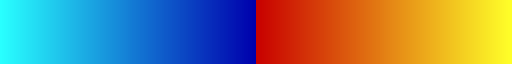

In [17]:
# cmap = cm.seismic
# cmap = cm.RdYlBu

## custom cmap
cblue = splt.cmap_i2f(ini='#29FFFF', fin='#0000AD')
cred = splt.cmap_i2f(ini='#C90000', fin='#FFFF29')
cmap = splt.cmap_combine(cblue,cred)
cmap

---

In [18]:
for cue in ['letter','spatial']:
    for cc in ['B','S','C','N']:
        cond = cc+'_%s'%cue
        psc, tmap = get_data(cond=cond, thresh=thresh)
    
        x = np.nanmin(np.abs(psc))
        y = np.nanmax(np.abs(psc))
        print(cond, '[%f, %f]'%(x,y))

B_letter [0.006069, 1.767893]
S_letter [0.029992, 1.854084]
C_letter [0.035241, 1.786857]
N_letter [0.020569, 1.802120]
B_spatial [0.029166, 2.210715]
S_spatial [0.019608, 2.163780]
C_spatial [0.015233, 2.230254]
N_spatial [0.011740, 2.138909]


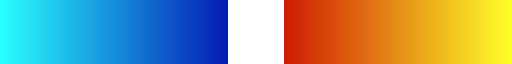

In [19]:
vmax = 1.8
ttt = 0.2
cscale=[-vmax,vmax]
cmap = splt.cmap_norm(cmap=cmap, vmax=vmax, thresh=ttt, alpha=0)
cmap

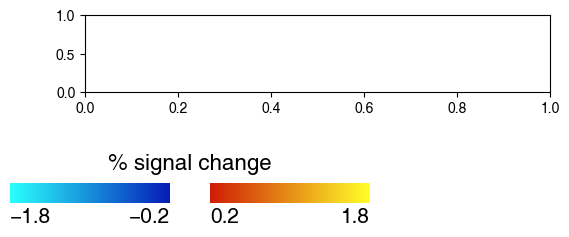

In [20]:
# ScalarMappable 생성 (데이터 없이 colormap과 norm만 지정)
norm = mpl.colors.Normalize(vmin=cscale[0], vmax=cscale[1])
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # 빈 데이터 연결 (필수)

# Figure와 colorbar 생성
fig, ax = plt.subplots(figsize=(6, 1))
cax = fig.add_axes(rect=[0, -1, 0.6, 0.2])  

cbar = fig.colorbar(sm, cax=cax, location='bottom', orientation='horizontal')
cbar.ax.tick_params(labelsize=13)
# cbar.set_label('% signal change', fontsize=16)
cbar.ax.set_title('% signal change', fontsize=16, pad=10)

for spine in cbar.ax.spines.values():
    spine.set_visible(False)
cbar.ax.tick_params(size=0, labelsize=15)   # tick 선 길이 제거
cbar.set_ticks([-vmax, -ttt, ttt, vmax])
# cbar.ax.tick_params(labelsize=0)  # tick 라벨 제거

for ii, label in enumerate(cbar.ax.get_xticklabels()):
    if ii%2==0:
        ha = 'left'
    else:
        ha = 'right'
    label.set_ha(ha)  

In [36]:
border, brdr = simage.get_border(dir_git=dir_git, atlas='sulcus'); bordersize=1
# border, brdr = simage.get_border(dir_git=dir_git, atlas='Glasser'); bordersize=0.15

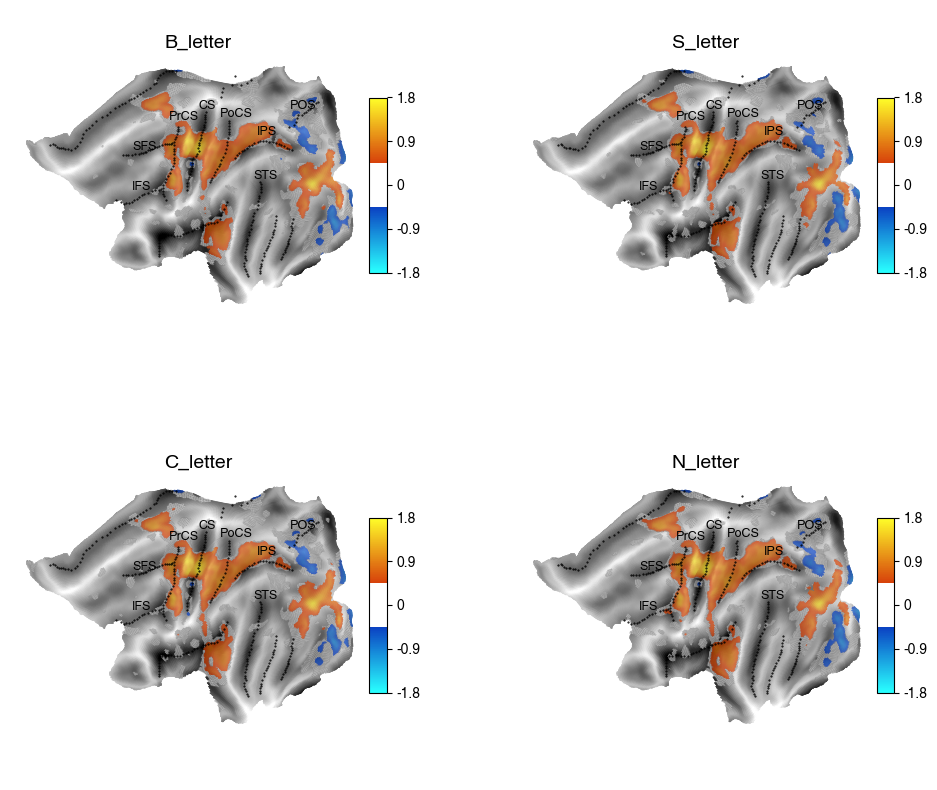

In [37]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12,10))
axs = np.concatenate(axs)

cue = 'letter'
for ii, cc in enumerate(['B','S','C','N']):
    ax = axs[ii]
    plt.sca(ax)
    
    cond = cc+'_%s'%cue
    psc, tmap = get_data(cond=cond, thresh=thresh)
    psc[np.abs(psc)<ttt] = np.nan
    
    color = 'black'
    g = surf.plot.plotmap(
        data=psc,
        surf='fs32k_%s'%hem,
        alpha=0.7,
        cmap=cmap, colorbar=True,
        cscale=cscale,
        # threshold=[-thresh,thresh],
        borders=border, bordercolor=color, bordersize=bordersize,
        overlay_type='func', render='matplotlib',
    )
    g.text(x=20, y=220, s=cond, ha='center', va='center', fontsize=14)
    for line, (x, y) in brdr.items():
        g.text(x=x, y=y, s=line, ha='left', va='bottom', color=color, fontsize=9)

### Spatial

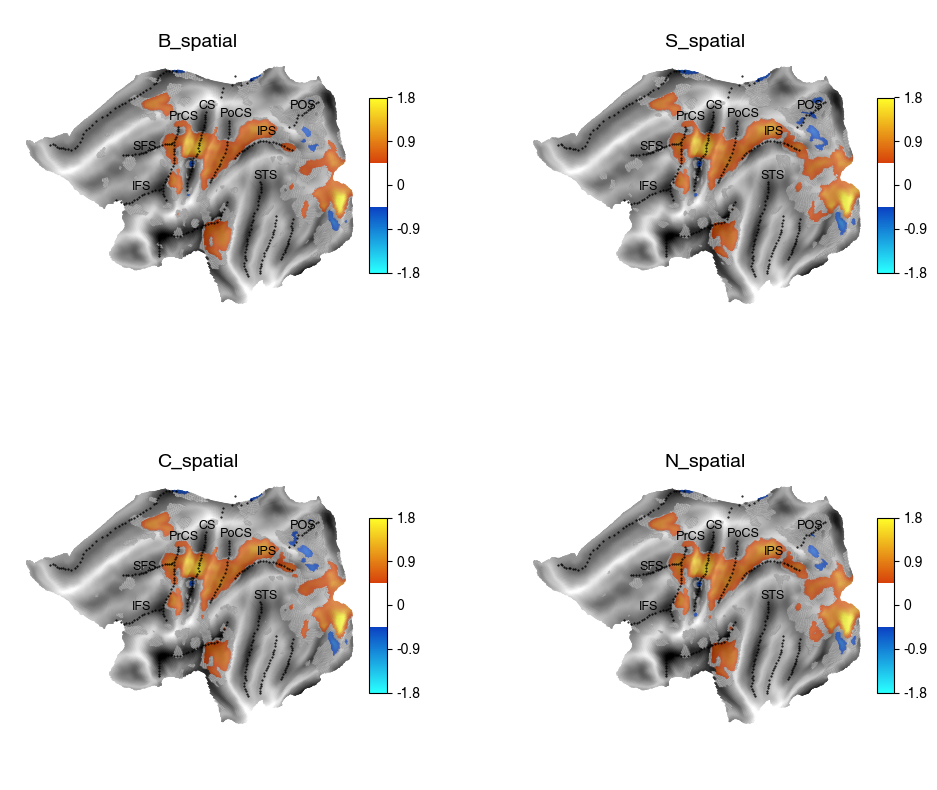

In [38]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12,10))
axs = np.concatenate(axs)

cue = 'spatial'
for ii, cc in enumerate(['B','S','C','N']):
    ax = axs[ii]
    plt.sca(ax)
    
    cond = cc+'_%s'%cue
    psc, tmap = get_data(cond=cond, thresh=thresh)
    psc[np.abs(psc)<ttt] = np.nan
    
    color = 'black'
    g = surf.plot.plotmap(
        data=psc,
        surf='fs32k_%s'%hem,
        alpha=0.7,
        cmap=cmap, colorbar=True,
        cscale=cscale,
        # threshold=[-thresh,thresh],
        borders=border, bordercolor=color, bordersize=bordersize,
        overlay_type='func', render='matplotlib',
    )
    g.text(x=20, y=220, s=cond, ha='center', va='center', fontsize=14)
    for line, (x, y) in brdr.items():
        g.text(x=x, y=y, s=line, ha='left', va='bottom', color=color, fontsize=9)

---

In [21]:
for cue in ['letter','spatial']:
    for cc in ['within','between']:
        cond = cc+'_%s'%cue
        psc, tmap = get_data(cond=cond, thresh=thresh)
    
        x = np.nanmin(np.abs(psc))
        y = np.nanmax(np.abs(psc))
        print(cond, '[%f, %f]'%(x,y))

within_letter [0.016399, 0.277744]
between_letter [0.012552, 0.236923]
within_spatial [0.026564, 0.285426]
between_spatial [0.009226, 0.248756]


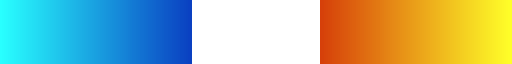

In [22]:
vmax = 0.2
ttt = 0.05
cscale=[-vmax,vmax]
cmap = splt.cmap_norm(cmap=cmap, vmax=vmax, thresh=ttt, alpha=0)
cmap

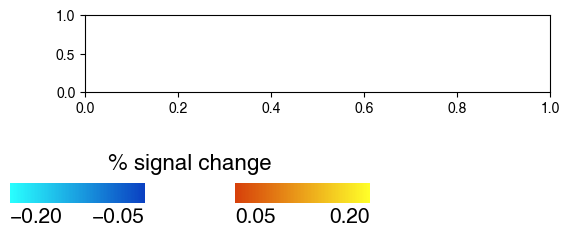

In [23]:
# ScalarMappable 생성 (데이터 없이 colormap과 norm만 지정)
norm = mpl.colors.Normalize(vmin=cscale[0], vmax=cscale[1])
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # 빈 데이터 연결 (필수)

# Figure와 colorbar 생성
fig, ax = plt.subplots(figsize=(6, 1))
cax = fig.add_axes(rect=[0, -1, 0.6, 0.2])  

cbar = fig.colorbar(sm, cax=cax, location='bottom', orientation='horizontal')
cbar.ax.tick_params(labelsize=13)
cbar.ax.set_title('% signal change', fontsize=16, pad=10)

for spine in cbar.ax.spines.values():
    spine.set_visible(False)
cbar.ax.tick_params(size=0, labelsize=15)   # tick 선 길이 제거
cbar.set_ticks([-vmax, -ttt, ttt, vmax])
# cbar.ax.tick_params(labelsize=0)  # tick 라벨 제거

for ii, label in enumerate(cbar.ax.get_xticklabels()):
    if ii%2==0:
        ha = 'left'
    else:
        ha = 'right'
    label.set_ha(ha)  

### within Cue

In [42]:
border, brdr = simage.get_border(dir_git=dir_git, atlas='sulcus'); bordersize=1
# border, brdr = simage.get_border(dir_git=dir_git, atlas='Glasser'); bordersize=0.15

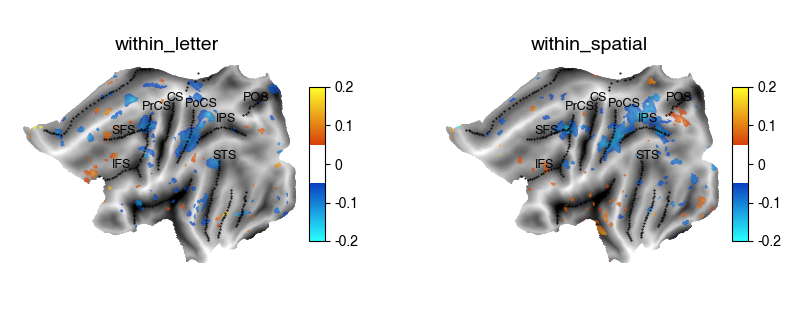

In [43]:
fig, axs = plt.subplots(ncols=2, figsize=(10,4))

for ii, cond in enumerate(['within_letter','within_spatial']):
    ax=axs[ii]
    plt.sca(ax)
    
    psc, tmap = get_data(cond=cond, thresh=thresh)
    psc[np.abs(psc)<ttt] = np.nan
    
    color = 'black'
    g = surf.plot.plotmap(
        data=psc,
        surf='fs32k_%s'%hem,
        alpha=0.7,
        cmap=cmap, colorbar=True,
        cscale=cscale,
        # threshold=[-thresh,thresh],
        borders=border, bordercolor=color, bordersize=bordersize,
        overlay_type='func', render='matplotlib',
    )
    g.text(x=20, y=220, s=cond, ha='center', va='center', fontsize=14)
    for line, (x, y) in brdr.items():
        g.text(x=x, y=y, s=line, ha='left', va='bottom', color=color, fontsize=9)

In [44]:
# dir_result = join(dir_current)
# fig.savefig(
#     join(dir_result, 'wRS.png'),
#     dpi=300, facecolor=[1,1,1,1], bbox_inches = "tight"
# )

### between Cue

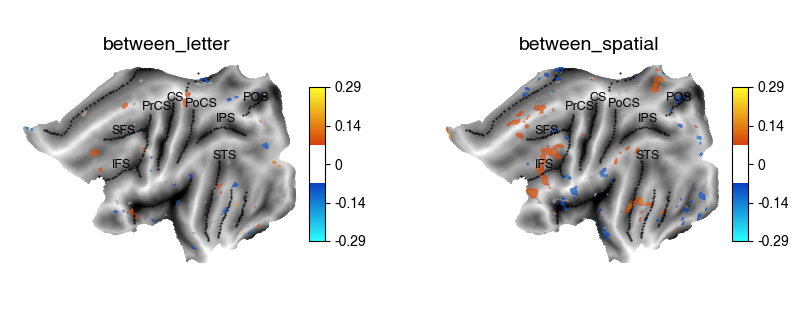

In [45]:
fig, axs = plt.subplots(ncols=2, figsize=(10,4))

for ii, cond in enumerate(['between_letter','between_spatial']):
    ax=axs[ii]
    plt.sca(ax)

    psc, tmap = get_data(cond=cond, thresh=thresh)
    psc[np.abs(psc)<ttt] = np.nan
    
    color = 'black'
    g = surf.plot.plotmap(
        data=psc,
        surf='fs32k_%s'%hem,
        alpha=0.7,
        cmap=cmap, colorbar=True,
        cscale=[-.29,.29],
        # threshold=[-thresh,thresh],
        borders=border, bordercolor=color, bordersize=bordersize,
        overlay_type='func', render='matplotlib',
    )
    g.text(x=20, y=220, s=cond, ha='center', va='center', fontsize=14)
    for line, (x, y) in brdr.items():
        g.text(x=x, y=y, s=line, ha='left', va='bottom', color=color, fontsize=9)

In [46]:
# fig.savefig(
#     join(dir_result, 'acRS.png'),
#     dpi=300, facecolor=[1,1,1,1], bbox_inches = "tight"
# )

---
---

In [45]:
border, brdr = simage.get_border(dir_git=dir_git, atlas='sulcus')
# border, brdr = simage.get_border(dir_git=dir_git, atlas='Glasser')

In [46]:
def plot_surf(data, cmap=cm.jet, title=None):
    if isinstance(data, str):
        data = nb.load(data).darrays[0].data
    elif isinstance(surf, nb.gifti.gifti.GiftiImage):
        data = data.darrays[0].data
    elif isinstance(surf, nb.gifti.gifti.GiftiDataArray):
        data = data.data

    g = surf.plot.plotmap(
        data=data,
        surf='fs32k_%s'%hem,
        alpha=0.7,
        cmap=cmap,
        # colorbar=True,
        # cscale=[-1,7],
        # threshold=[-thresh,thresh],
        borders=border, bordercolor='white', bordersize=1,
        overlay_type='func', render='matplotlib',
    )
    g.text(x=20, y=220, s=title, ha='center', va='center', fontsize=10)
    for line, (x, y) in brdr.items():
        g.text(x=x, y=y, s=line, ha='left', va='bottom', color='white', fontsize=10)

    return g

In [47]:
# fname = join(dir_git,'fs_LR_32/ROI.32k.%s.label.gii'%hem)
# mask = nb.load(fname).darrays[0].data

fname = join(dir_roi,'SPark2025.32k.L.label.gii')
gii = nb.load(fname)
mask = gii.darrays[0].data

In [48]:
list_roi = []
for ii, label in enumerate(gii.labeltable.labels):
    if ii>0:
        list_roi.append(label.label)
list_roi = np.array(list_roi)
list_roi

array(['S1', 'M1', 'SMA', 'PMd', 'PMv', 'SPLa', 'SPLp', 'IPS', 'V4d',
       'Vf', 'Vd', 'Vv', 'POS', 'PGi'], dtype='<U4')

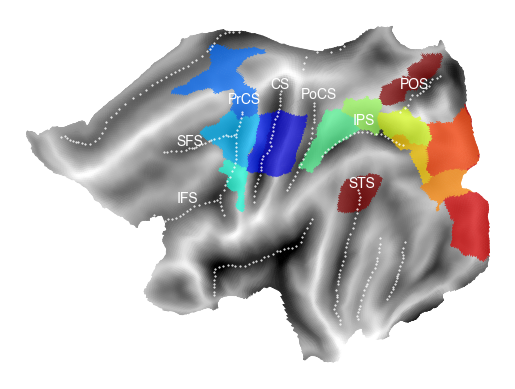

In [49]:
N = len(list_roi)
g = plot_surf(mask, cmap=cm.jet.resampled(N))

In [50]:
def get_df(list_cond):
    df = pd.DataFrame(columns=['roi', 'cue', 'cond', *['S'+sn for sn in list_sn]])
    for aa, cue in enumerate(['letter','spatial']):
        for bb, cond in enumerate(list_cond):
            fname = join(dir_work,'smooth.cifti.%s.glm_%1d.beta_mean.%s_%s.dscalar.nii'%(hem,glm,cond,cue))
            cii = nb.load(fname)
            data = cii.get_fdata()
            for ii, roi in enumerate(list_roi):
                row = aa*len(list_cond)*len(list_roi) + bb*len(list_roi) + ii
                val = ii+1
                idx = mask==val
                # nvoxels = (idx).sum()
                # print(val, roi, nvoxels)
            
                tmp = data[:,idx].mean(axis=1)
            
                df.loc[row,'roi'] = roi
                df.loc[row,'cue'] = cue
                df.loc[row,'cond'] = cond
                for jj, psc in enumerate(tmp):
                    subj = 'S'+list_sn[jj]
                    df.loc[row,subj] = psc
    return df

In [51]:
dir_work = join(dir_surf,'glm_%1d'%glm)

list_cond = ['B','S','C','N']
dg = get_df(list_cond)

list_cond = ['within','between']
df = get_df(list_cond)

In [52]:
dg = pd.melt(
    dg,
    id_vars=['roi','cue','cond'],
    value_vars=['S'+sn for sn in list_sn], var_name='subj',
    value_name='psc'
)
# dg['hue'] = ['%s_%s'%(cond,cue) for cond, cue in zip(dg.cond, dg.cue)]
dg

,roi,cue,cond,subj,psc
0,S1,letter,B,S01,0.530438
1,M1,letter,B,S01,0.858112
2,SMA,letter,B,S01,0.389118
3,PMd,letter,B,S01,0.513463
4,PMv,letter,B,S01,0.408421
...,...,...,...,...,...
1339,Vf,spatial,N,S14,0.226582
1340,Vd,spatial,N,S14,-0.258673
1341,Vv,spatial,N,S14,0.218549
1342,POS,spatial,N,S14,-0.185577


In [53]:
palette = ['#d71b3b','#7a2048','#16acea','#4203c9']

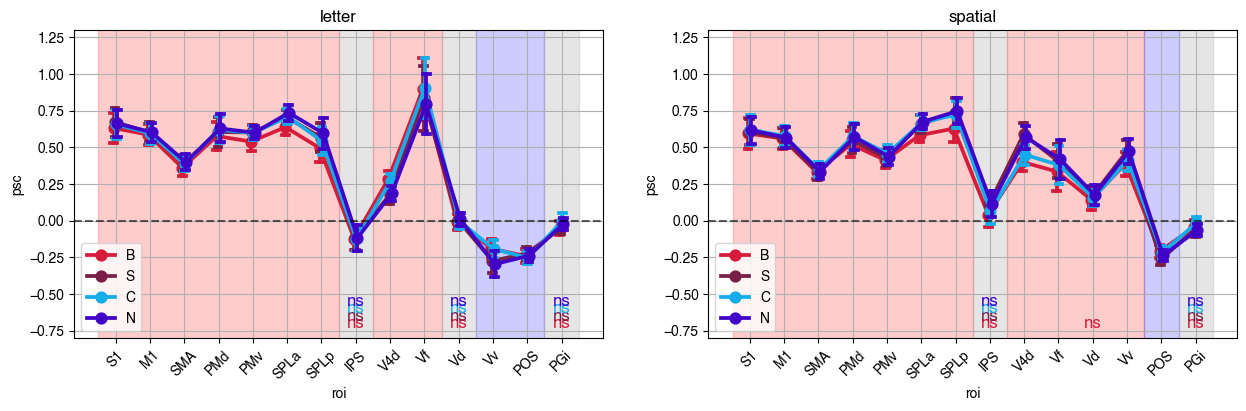

In [54]:
fig, axs = plt.subplots(ncols=2, figsize=(15,4))

for ii, cue in enumerate(['letter','spatial']):
    ax = axs[ii]
    plt.sca(ax)
    g = sns.pointplot(
        data=dg[dg.cue==cue],
        x='roi', y='psc', hue='cond',
        errorbar='se', capsize=0.2,
        dodge=True,
        palette=palette
    )
    g.legend(loc='best')
    g.grid(axis='both')
    xticks = np.array(g.get_xticks()); g.set_xticks(xticks) 
    xticklabels = g.get_xticklabels(); g.set_xticklabels(xticklabels, rotation=45)
    g.set_ylim(-0.8,1.3)
    g.axhline(y=0, linestyle='--', color='black', alpha=0.6)
    g.set_title(cue, fontsize=12)

    ## shader
    tmp = np.append(xticks,xticks[-1]+1)
    if cue == 'letter':
        x_red = {}
        x_red[1] = [0,6]
        x_red[2] = [8,9]
        x_blue = {}
        x_blue[1] = [11,12]
        x_gray = {}
        x_gray[1] = [7,7]
        x_gray[2] = [10,10]
        x_gray[3] = [13,13]
    elif cue == 'spatial':
        x_red = {}
        x_red[1] = [0,6]
        x_red[2] = [8,11]
        x_blue = {}
        x_blue[1] = [12,12]
        x_gray = {}
        x_gray[1] = [7,7]
        x_gray[2] = [13,13]
        
    for x1, x2 in x_red.values():    
        g.fill_between(
                x=tmp-0.5,
                y1=-100, y2=100,
                where=(tmp>=x1)&(tmp<=x2+1),
                color='red', alpha=0.2
            )
    for x1, x2 in x_blue.values():    
        g.fill_between(
                x=tmp-0.5,
                y1=-100, y2=100,
                where=(tmp>=x1)&(tmp<=x2+1),
                color='blue', alpha=0.2
            )
    for x1, x2 in x_gray.values():    
        g.fill_between(
                x=tmp-0.5,
                y1=-100, y2=100,
                where=(tmp>=x1)&(tmp<=x2+1),
                color='gray', alpha=0.2
            )

    ## one sample t-test
    for jj, roi in enumerate(list_roi):
        for kk, c in enumerate(['B','S','C','N']):
            a = dg[(dg.cue==cue)&(dg.roi==roi)&(dg.cond==c)].psc.astype(float)
            res = ttest_1samp(a=a, popmean=0, alternative='two-sided')
            if res.pvalue > 0.05:
                x = jj
                # y = a.mean()+a.sem() + 5
                y = -0.7 + kk*0.05
                g.text(
                    x=x, y=y,
                    s=sstat.convert_pval_to_star(res.pvalue), fontsize=12,
                    color=palette[kk],
                    ha='center', va='center'
                )
            # else:
            #     print(roi, 't(%d)=%.4f, p=%.3e(%s)'%(res.df,res.statistic,res.pvalue,sstat.convert_pval_to_star(res.pvalue)))

In [55]:
df = pd.melt(
    df,
    id_vars=['roi','cue','cond'],
    value_vars=['S'+sn for sn in list_sn], var_name='subj',
    value_name='psc'
)
# df['hue'] = ['%s_%s'%(cond,cue) for cond, cue in zip(df.cond, df.cue)]
df = df.set_index('subj', drop=False)
df

,roi,cue,cond,subj,psc
subj,,,,,
S01,S1,letter,within,S01,0.017898
S01,M1,letter,within,S01,-0.036348
S01,SMA,letter,within,S01,0.024605
S01,PMd,letter,within,S01,-0.038588
S01,PMv,letter,within,S01,-0.071369
...,...,...,...,...,...
S14,Vf,spatial,between,S14,-0.058134
S14,Vd,spatial,between,S14,0.091475
S14,Vv,spatial,between,S14,0.065605


In [56]:
palette = ['#1d3c45','#d2601a']

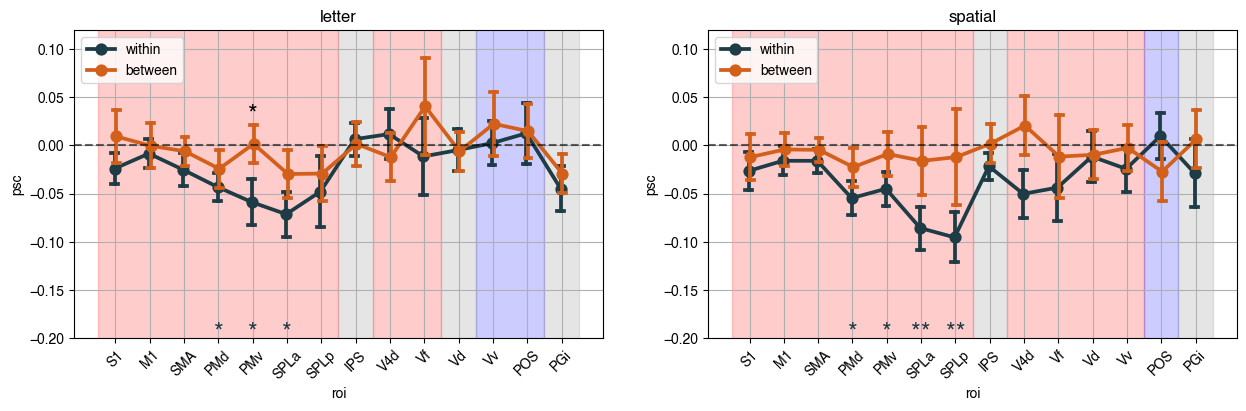

In [63]:
fig, axs = plt.subplots(ncols=2, figsize=(15,4))

for ii, cue in enumerate(['letter','spatial']):
    ax = axs[ii]
    plt.sca(ax)
    g = sns.pointplot(
        data=df[df.cue==cue],
        x='roi', y='psc', hue='cond',
        errorbar='se', capsize=0.2,
        dodge=True,
        palette=palette
    )
    g.legend(loc='upper left')
    g.grid(axis='both')
    g.set_xticks(g.get_xticks())
    xticklabels = g.get_xticklabels()
    g.set_xticklabels(xticklabels, rotation=45)
    # g.set_ylim(-0.0095,0.008)
    g.set_ylim(-0.2,0.12)
    g.axhline(y=0, linestyle='--', color='black', alpha=0.6)
    g.set_title(cue, fontsize=12)

    ## shader
    tmp = np.append(xticks,xticks[-1]+1)
    if cue == 'letter':
        x_red = {}
        x_red[1] = [0,6]
        x_red[2] = [8,9]
        x_blue = {}
        x_blue[1] = [11,12]
        x_gray = {}
        x_gray[1] = [7,7]
        x_gray[2] = [10,10]
        x_gray[3] = [13,13]
    elif cue == 'spatial':
        x_red = {}
        x_red[1] = [0,6]
        x_red[2] = [8,11]
        x_blue = {}
        x_blue[1] = [12,12]
        x_gray = {}
        x_gray[1] = [7,7]
        x_gray[2] = [13,13]

        
    for x1, x2 in x_red.values():    
        g.fill_between(
                x=tmp-0.5,
                y1=-100, y2=100,
                where=(tmp>=x1)&(tmp<=x2+1),
                color='red', alpha=0.2
            )
    for x1, x2 in x_blue.values():    
        g.fill_between(
                x=tmp-0.5,
                y1=-100, y2=100,
                where=(tmp>=x1)&(tmp<=x2+1),
                color='blue', alpha=0.2
            )
    for x1, x2 in x_gray.values():    
        g.fill_between(
                x=tmp-0.5,
                y1=-100, y2=100,
                where=(tmp>=x1)&(tmp<=x2+1),
                color='gray', alpha=0.2
            )

    ## one sample t-test
    for jj, roi in enumerate(list_roi):
        for kk, c in enumerate(['within','between']):
            a = df[(df.cue==cue)&(df.roi==roi)&(df.cond==c)].psc.astype(float)
            res = ttest_1samp(a=a, popmean=0, alternative='two-sided')
            if res.pvalue < 0.05:
                # print('(%s) %s_%s'%(cue,roi,c), 't(%d)=%.4f, p=%.3e(%s)'%(res.df,res.statistic,res.pvalue,sstat.convert_pval_to_star(res.pvalue)))
                x = jj
                y = -0.195 + kk*0.01
                g.text(
                    x=x, y=y,
                    s=sstat.convert_pval_to_star(res.pvalue), fontsize=18,
                    color=palette[kk],
                    ha='center', va='center'
                )
            # else:
                # print('\033[31m(%s) %s_%s'%(cue,roi,c), 't(%d)=%.4f, p=%.3e(%s)\033[0m'%(res.df,res.statistic,res.pvalue,sstat.convert_pval_to_star(res.pvalue)))
    
    ## paired t-test
    for jj, roi in enumerate(list_roi):
        a = df[(df.cue==cue)&(df.roi==roi)&(df.cond=='within')].psc.astype(float)
        b = df[(df.cue==cue)&(df.roi==roi)&(df.cond=='between')].psc.astype(float)
        res = ttest_rel(a=a, b=b)
        if res.pvalue < 0.05:
            # print(roi, 't(%d)=%.4f, p=%.3e(%s)'%(res.df,res.statistic,res.pvalue,sstat.convert_pval_to_star(res.pvalue)))
            x = jj
            amax, amin = a.mean()+a.sem(), a.mean()-a.sem()
            bmax, bmin = b.mean()+b.sem(), b.mean()-b.sem()
            y = max(amax, bmax)+0.01
            # color = palette[0] if a.mean()>b.mean() else palette[1]
            color = 'black'
            g.text(
                x=x, y=y,
                s=sstat.convert_pval_to_star(res.pvalue), fontsize=18,
                color=color,
                ha='center', va='center'
            )

---